# LAB 6 - Deep Computer Vision with Fine-Tuned Pre-trained Vision Transformer (ViT) using Pytorch for Transfer Learning in Oftalmology
The objective of this lab is to understand the fundamentals of Vision Transformer architectures

#### Project Info

 ->Copyright 2024 Luis R Soenksen

 ->Last Update: March 24, 2024

```
**Licensed under the Apache License, Version 2.0**
You may not use this file except in compliance with the License. You may obtain a copy of the License at
https://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.
```

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Compatible with Google Colab</a>      
    </td>
  <td>
    <a target="_blank" href="https://github.com/lrsoenksen/"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />Visit my GitHub</a>
  </td>
  <td>
    <a href="https://pytorch.org"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c6/PyTorch_logo_black.svg/488px-PyTorch_logo_black.svg.png" width="150px"/>Built with Pytorch </a>
  </td>
</table>

------------------------------------------------------

## Introduction

Similar to the impact transformer-based models have had on NLP, their application is now rapidly expanding into various other fields. One groundbreaking example is the Vision Transformer (ViT), introduced by researchers at Google Brain in [June 2021](https://arxiv.org/abs/2010.11929). The ViT model utilizes the Transformer architecture with self-attention on sequences of image patches, bypassing the need for convolution layers.

This example demonstrates how to tokenize images in a manner akin to tokenizing sentences, allowing them to be processed by transformer models for training. The procedure is as follows:

1. Divide an image into a grid of smaller patches.
2. Apply a linear projection to each patch.
3. Treat each embedded patch as a token, forming a sequence of these tokens to feed into the model.

![vit_figure.png](https://raw.githubusercontent.com/google-research/vision_transformer/main/vit_figure.png)

By following these steps, you can pre-train and fine-tune transformers similarly to how you would for NLP tasks.

In this notebook, we will guide you through using 🤗 `kaggle datasets` to download and prepare image classification datasets, and then train a ViT from scratch.


### **Step 0) Setup system and import required packages**

In [2]:
!pip install medmnist
!pip install torch torchvision
!pip install transformers datasets evaluate
!pip install transformers[torch]
!pip install torchmetrics
!pip install datasets
!pip install evaluate
!pip install accelerate
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
zsh:1: no matches found: transformers[torch]

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: pip install --upgrade pip
  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /private/var/folders/9y/6n0hmt613jb47bbr5jnc4hf00000gn/T/pip-req-build-4fxlpc6i
  Running command git clone --filter

In [3]:
# Deep learning packages
import torch
import torch.nn as nn
from torch import utils
from torch import optim
from torch import device
from torch import inference_mode
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import Normalize, Resize, ToTensor, Compose, ToPILImage
from torchvision import transforms
from torchmetrics import ConfusionMatrix

import accelerate
import transformers
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset, DatasetDict, Features, Sequence, Image, ClassLabel
from evaluate import load

# Data management and Plotting
import random
import numpy as np
import tqdm
from tqdm.auto import tqdm
from PIL import Image as Img
import matplotlib.pyplot as plt
from textwrap import wrap
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import MedMNIST
import medmnist
from medmnist import INFO, Evaluator
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

ImportError: dlopen(/Users/sq/anaconda3/lib/python3.11/site-packages/torch/_C.cpython-311-darwin.so, 0x0002): Library not loaded: @rpath/libtorch_cpu.dylib
  Referenced from: <63AE8CCF-D4FA-352B-9B53-687059C01309> /Users/sq/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_python.dylib
  Reason: tried: '/Users/sq/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib' (no such file), '/Users/runner/work/_temp/anaconda/envs/wheel_py311/lib/libtorch_cpu.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/runner/work/_temp/anaconda/envs/wheel_py311/lib/libtorch_cpu.dylib' (no such file), '/Users/runner/work/_temp/anaconda/envs/wheel_py311/lib/libtorch_cpu.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/runner/work/_temp/anaconda/envs/wheel_py311/lib/libtorch_cpu.dylib' (no such file), '/Users/sq/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib' (no such file), '/Users/runner/work/_temp/anaconda/envs/wheel_py311/lib/libtorch_cpu.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/runner/work/_temp/anaconda/envs/wheel_py311/lib/libtorch_cpu.dylib' (no such file), '/Users/runner/work/_temp/anaconda/envs/wheel_py311/lib/libtorch_cpu.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/runner/work/_temp/anaconda/envs/wheel_py311/lib/libtorch_cpu.dylib' (no such file), '/Users/sq/anaconda3/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib' (no such file), '/Users/sq/anaconda3/bin/../lib/libtorch_cpu.dylib' (no such file), '/Users/sq/anaconda3/bin/../lib/libtorch_cpu.dylib' (no such file), '/usr/local/lib/libtorch_cpu.dylib' (no such file), '/usr/lib/libtorch_cpu.dylib' (no such file, not in dyld cache)

In [ ]:
# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
device

device(type='cuda')

### **Step 1) Load data**
**Dataset of Dermoscopy skin diseases**

MedMNIST, is a large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D. All images are pre-processed into 28x28 (2D) or 28x28x28 (3D) with the corresponding classification labels, so that no background knowledge is required for users. Covering primary data modalities in biomedical images, MedMNIST is designed to perform classification on lightweight 2D and 3D images with various data scales (from 100 to 100,000) and diverse tasks (binary/multi-class, ordinal regression and multi-label). The resulting dataset, consisting of approximately 708K 2D images and 10K 3D images in total, could support numerous research and educational purposes in biomedical image analysis, computer vision and machine learning. We benchmark several baseline methods on MedMNIST, including 2D / 3D neural networks and open-source / commercial AutoML tools. This example allows you to explore building models for most applications in MedMNIST.

For this specific example we will first use RetinaMNIST. The RetinaMNIST is based on the DeepDRiD24 challenge, which provides a dataset of 1,600 retina fundus images. The task is ordinal regression for 5-level grading of diabetic retinopathy severity. We split the source training set with a ratio of 9:1 into training and validation set, and use the source validation set as the test set. The source images of 3 × 1,736 × 1,824 are center-cropped with a window size of length of the short edge and resized into 3 × 28 × 28.


![overview.jpg](https://medmnist.com/assets/v2/imgs/overview.jpg)



Motivation:

*   To reduce the burden for expert dermatologists in resource-constrained regions and improve diagnostic accuracy.


Inputs:
*   Retina fundus images (1,600) with 5-level grading of diabetic retinopathy severity.


Outputs:
*   Clinical dictamination of diabetic retinopathy severity.
  *   Grade 0	no apparent retinopathy	no abnormalities
  *   Grade 1	mild NPDR	microaneurysms only
  *   Grade 2	moderate NPDR	between just microaneurysms and severe NPDR
  *   Grade 3	severe NPDR	any of the following:
more than 20 intraretinal hemorrhages in each of 4 quadrants;
definite venous beading in more than 2 quadrants; prominent
intraretinal microvascular abnormalities in more than 1
quadrant; no signs of PDR retinopathy
  *   Grade 4	PDR	one or more of the following:
neovascularization; vitreous/preretinal hemorrhage


References:

1.   PDeepDRiD. The 2nd diabetic retinopathy–grading and image quality estimation challenge. https://isbi.deepdr.org/data.html (2020).

In [ ]:
## Download and Split Datasets

# Data to use (USER CAN CHOOSE)
data_flag = 'retinamnist'
labels_map = {
    0: "Healthy",
    1: "Mild NPDR",
    2: "Moderate NPDR",
    3: "Severe NPDR",
    4: "PDR"} ## Specific for retinamnist

# Other possible data to use
# data_flag = 'pathmnist'
# data_flag = 'chestmnist'
# data_flag = 'dermamnist'
# data_flag = 'octmnist'
# data_flag = 'pneumoniamnist'
# data_flag = 'retinamnist'
# data_flag = 'breastmnist'
# data_flag = 'bloodmnist'
# data_flag = 'tissuemnist'
# data_flag = 'organamnist'
# data_flag = 'organcmnist'
# data_flag = 'organsmnist'

# Get data info
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# Number of image channels
n_channels = 3                                                                   #TO DO
print(f"number of channels: {n_channels}")

# Number of classes
n_classes =  len(labels_map)                                                    #TO DO
print(f"number of classes: {n_classes}")

# Get the class names from the dataset
class_names = labels_map                                                      #TO DO
print(f"class names: {labels_map}")

# Data split (use this for high resolution MedMNIST)                         #TO DO specify size required by ViT model
train_data = DataClass(split='train', download=True, size=28, mmap_mode='r')
val_data = DataClass(split='val', download=True, size=28, mmap_mode='r')
test_data = DataClass(split='test', download=True, size=28, mmap_mode='r')

# Data split (use this for low resolution MedMNIST)
#train_data = DataClass(split='train', download=True)
#val_data = DataClass(split='val', download=True)
#test_data = DataClass(split='test', download=True)

number of channels: 3
number of classes: 5
class names: {0: 'Healthy', 1: 'Mild NPDR', 2: 'Moderate NPDR', 3: 'Severe NPDR', 4: 'PDR'}
Using downloaded and verified file: C:\Users\qisun\.medmnist\retinamnist.npz
Using downloaded and verified file: C:\Users\qisun\.medmnist\retinamnist.npz
Using downloaded and verified file: C:\Users\qisun\.medmnist\retinamnist.npz


In [ ]:
# Display characteristics of data
train_data, test_data, val_data
print(train_data)
print("===================")
print(test_data)
print("===================")
print(val_data)
print("===================")

Dataset RetinaMNIST of size 28 (retinamnist)
    Number of datapoints: 1080
    Root location: C:\Users\qisun\.medmnist
    Split: train
    Task: ordinal-regression
    Number of channels: 3
    Meaning of labels: {'0': '0', '1': '1', '2': '2', '3': '3', '4': '4'}
    Number of samples: {'train': 1080, 'val': 120, 'test': 400}
    Description: The RetinaMNIST is based on the DeepDRiD challenge, which provides a dataset of 1,600 retina fundus images. The task is ordinal regression for 5-level grading of diabetic retinopathy severity. We split the source training set with a ratio of 9:1 into training and validation set, and use the source validation set as the test set. The source images of 3×1,736×1,824 are center-cropped and resized into 3×28×28.
    License: CC BY 4.0
Dataset RetinaMNIST of size 28 (retinamnist)
    Number of datapoints: 400
    Root location: C:\Users\qisun\.medmnist
    Split: test
    Task: ordinal-regression
    Number of channels: 3
    Meaning of labels: {'0': 

In [ ]:
# Make huggingface Dataset based on the MedMNIST imported dataset
features = Features({'image': Image(), 'label': Sequence(ClassLabel(names=['0', '1', '2', '3', '4']))})
train_ds = Dataset.from_dict({'image': [img for img, _ in train_data], 'label': [label for _, label in train_data]}, features=features)         #TO DO
val_ds = Dataset.from_dict({'image':[img for img, _ in val_data], 'label':[label for _, label in val_data]}, features=features)             #TO DO
test_ds = Dataset.from_dict({'image': [img for img, _ in test_data], 'label': [label for _, label in test_data]}, features=features)          #TO DO

ds = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds,
    })

NameError: name 'Features' is not defined

In [ ]:
# Data Preprocessing
def transform(examples):
  # convert all images to RGB format, then preprocessing it using our image processor
  inputs = image_processor([img.convert("RGB") for img in examples["image"]], return_tensors="pt")

  # we also shouldn't forget about the labels
  inputs["labels"] = examples["label"]

  return inputs

In [ ]:
# Use  with_transform() method to apply the transform to the dataset on the fly during training
dataset = ds.with_transform(transform)

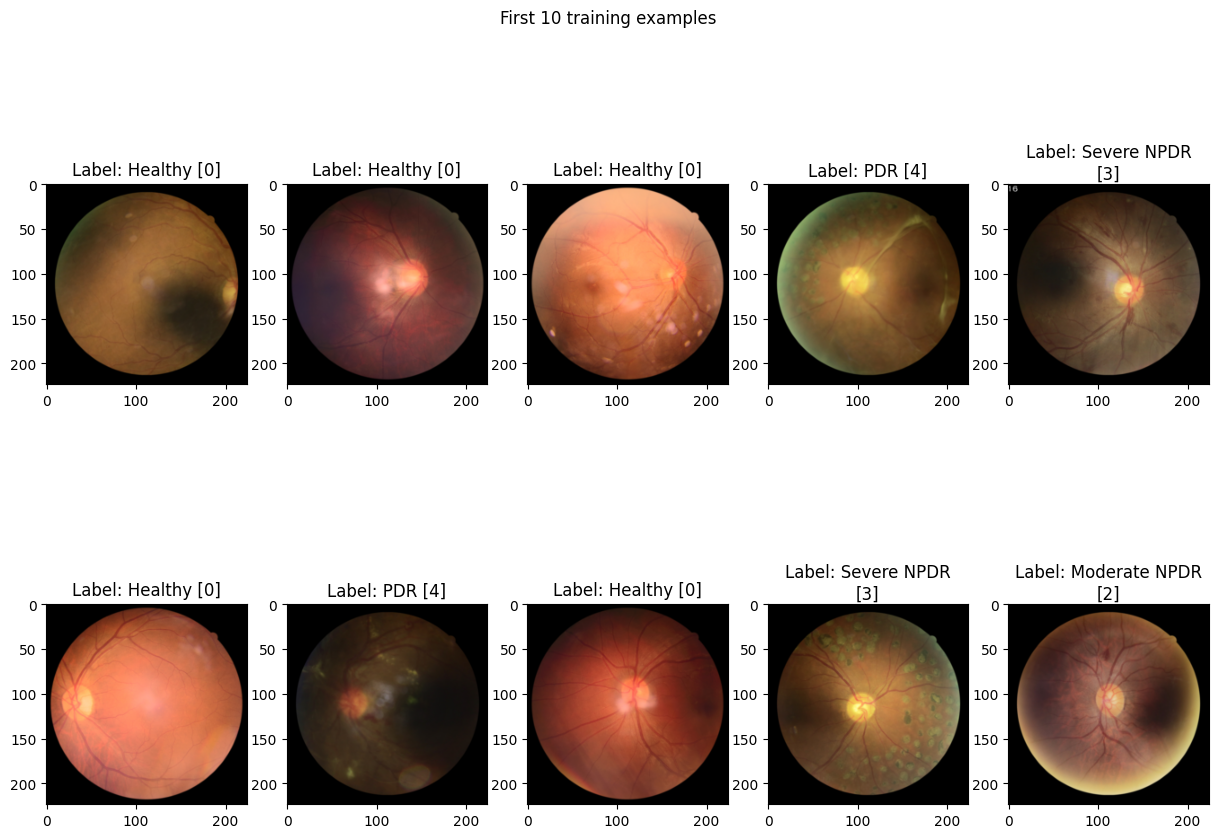

In [ ]:
# Plot some data samples with labels
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 10))
axs = axs.ravel()

# Iterate through images in train dataloader
i = 0
while i < len(axs):
  images = train_data.imgs[i]
  labels = train_data.labels[i]
  axs[i].imshow(images)
  axs[i].set_title("\n".join(wrap(f"Label: {labels_map[labels[0].item()]}"+ " [" + str(labels[0].item())+ "]", 20)), wrap=True)
  i += 1

plt.suptitle(f"First {len(axs)} training examples")
plt.show()

/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:32: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


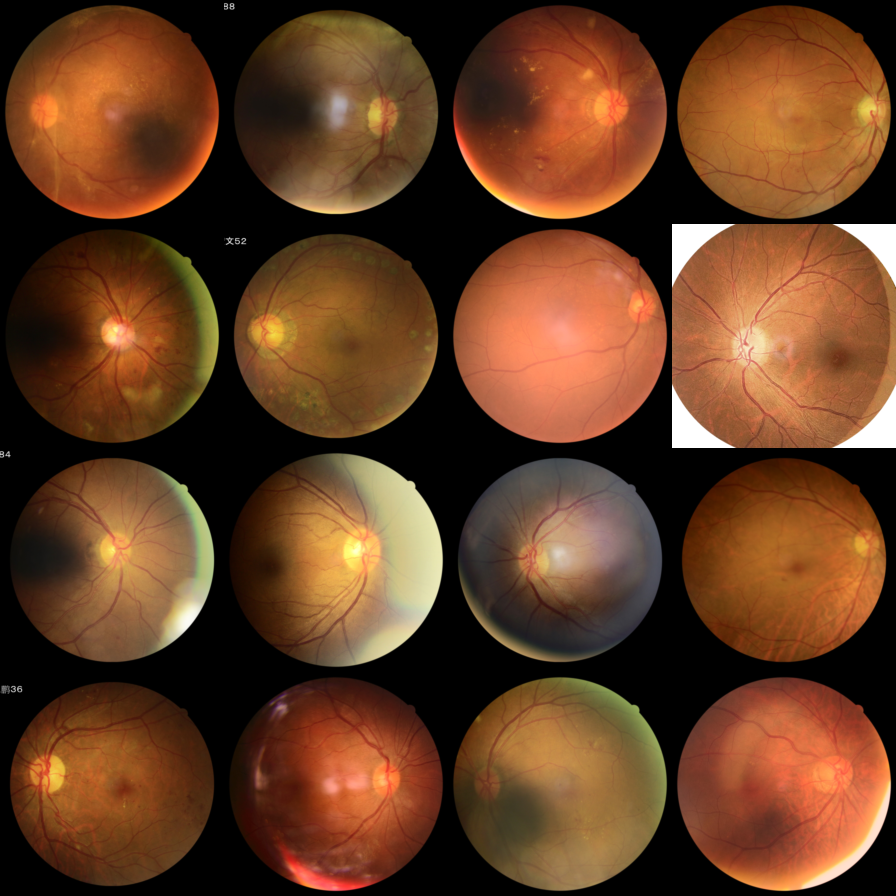

In [ ]:
# Show montage of all types of images
train_data.montage(length=4)

### **Step 2) Define and Train Model**

In [ ]:
### Foundational model (pre-trained)
model_name = "google/vit-base-patch16-224"                        # the model name

### Model image processor
image_processor =                                                              #TO DO load the image processor
print('Model Input Size: ' + str(image_processor.size))

### Model - Fine Tuning
model =                                                                        #TO DO load ImageNet pretrained model and print classifier
print(model.classifier)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Model Input Size: {'height': 224, 'width': 224}


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Linear(in_features=768, out_features=1000, bias=True)


In [ ]:
# Helper function to show images
def show_image(dataset, split, index):
    data = dataset[split][index]
    if "image" in data:  # Original dataset
        image = data["image"]
        label = data["label"]

        plt.figure(figsize=(1, 1))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Class {label}", fontsize=8)
        plt.show()
    else:  # Transformed dataset
        image_tensor = data['pixel_values']
        label = data['labels']

        # Convert the tensor to a NumPy array and display the image
        image_array = image_tensor.numpy()  # Convert the torch tensor to a NumPy array
        plt.figure(figsize=(1, 1))
        plt.imshow(image_array.transpose(1, 2, 0))  # Matplotlib expects the channel dimension last
        plt.title(f"Class {label}", fontsize=8)
        plt.axis('off')  # Hide the axis
        plt.show()

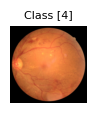

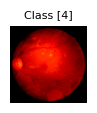

In [ ]:
idx = 10
show_image(ds, "train", idx)
show_image(dataset, "train", idx)

In [ ]:
# Helper function to feed data into ViT during training
def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"][0] for x in batch]),
  }

In [ ]:
# load the accuracy and f1 metrics from the evaluate module
accuracy = load("accuracy")
f1 = load("f1")

def compute_metrics(eval_pred): #compute_metrics needs to be passed to Trainer() below
  # compute the accuracy and f1 scores & return them
  accuracy_score = accuracy.compute(predictions=, references=)#TO DO
  f1_score = f1.compute(predictions=, references=, average="macro")#TO DO
  return {**accuracy_score, **f1_score}

In [ ]:
# load the ViT model
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=,                                                                #TO DO
    id2label={str(i): c for i, c in enumerate(list(class_names.values()))},
    label2id={c: str(i) for i, c in enumerate(list(class_names.values()))},
    ignore_mismatched_sizes=True,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# defining the training arguments
training_args = TrainingArguments(
  output_dir="./vit-base-retina", # output directory
  per_device_train_batch_size=32, # batch size per device during training
  evaluation_strategy="steps",    # evaluation strategy to adopt during training
  num_train_epochs=                                                            #TO DO total number of training epochs
  save_steps=                                                                  #TO DO number of update steps before saving checkpoint
  eval_steps=                                                                  #TO DO number of update steps before evaluating
  logging_steps=                                                               #TO DO number of update steps before logging
  save_total_limit=2,             # limit the total amount of checkpoints on disk
  remove_unused_columns=False,    # remove unused columns from the dataset
  push_to_hub=False,              # do not push the model to the hub
  report_to='tensorboard',        # report metrics to tensorboard
  load_best_model_at_end=True,    # load the best model at the end of training
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Create Trainer
from transformers import Trainer

trainer = Trainer(                                                              #TO DO
    model=,                        # the instantiated 🤗 Transformers model to be trained
    args=,                 # training arguments, defined above
    data_collator=,           # the data collator that will be used for batching
    compute_metrics=,    # the metrics function that will be used for evaluation
    train_dataset=,     # training dataset
    eval_dataset=, # evaluation dataset
    tokenizer=,          # the processor that will be used for preprocessing the images
)

In [ ]:
## Train Model
                                                                                #TO DO

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Step,Training Loss,Validation Loss,Accuracy,F1
34,1.128800,0.932429,0.633333,0.438985
68,0.708000,0.924256,0.625000,0.516728
102,0.379700,0.928111,0.633333,0.444103
136,0.146200,0.934643,0.758333,0.590949
170,0.048900,0.977841,0.733333,0.601572
204,0.022700,1.166058,0.675000,0.522027
238,0.006600,1.258735,0.666667,0.527894
272,0.003500,1.287693,0.700000,0.548494
306,0.002800,1.300033,0.700000,0.548494
340,0.002500,1.308007,0.691667,0.543964


TrainOutput(global_step=340, training_loss=0.24496885338688598, metrics={'train_runtime': 481.7008, 'train_samples_per_second': 22.421, 'train_steps_per_second': 0.706, 'total_flos': 8.369359908102144e+17, 'train_loss': 0.24496885338688598, 'epoch': 10.0})

In [ ]:
## Test Model
                                                                                #TO DO evaluate model on test set
                                                                                #points for accuracy > 50%

{'eval_loss': 0.47200989723205566,
 'eval_accuracy': 0.8740740740740741,
 'eval_f1': 0.849268707581159,
 'eval_runtime': 14.5184,
 'eval_samples_per_second': 74.388,
 'eval_steps_per_second': 9.299,
 'epoch': 10.0}

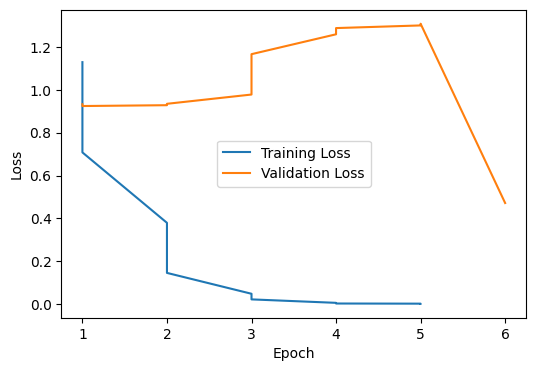

In [ ]:
## Generate Training & Loss Curves

data = trainer.state.log_history
# Extracting data for plotting
epochs = [entry['epoch'] for entry in data]  # Extract epoch values
train_losses = [entry['loss'] for entry in data if 'loss' in entry]  # Extract training losses
eval_losses = [entry['eval_loss'] for entry in data if 'eval_loss' in entry]  # Extract evaluation losses

# Plotting training and evaluation metrics
plt.figure(figsize=(6, 4))

plt.plot(epochs[:len(train_losses)], train_losses, label='Training Loss')
plt.plot(epochs[:len(eval_losses)], eval_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title('Training and Evaluation Metrics Across Epochs')
plt.legend()
# plt.grid(True)
plt.show()

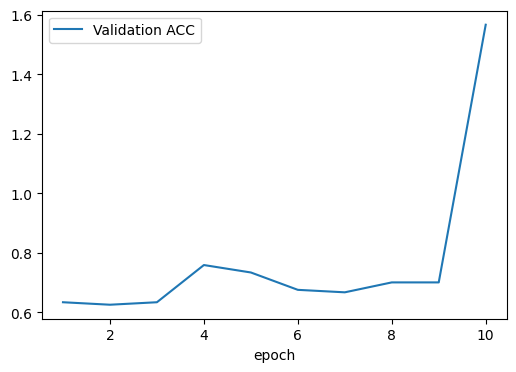

In [ ]:
import pandas as pd

loghistory = pd.DataFrame(trainer.state.log_history)
loghistory = loghistory.fillna(0)
loghistory = loghistory.groupby(['epoch']).sum()
fig, ax = plt.subplots(figsize=(6, 4))  # Set the size here (width, height)
loghistory[["eval_accuracy"]].plot(subplots=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Validation ACC'], loc='best')
plt.show()  # Display the plot

In [ ]:
dataset["train"].features['label']

Sequence(feature=ClassLabel(names=['0', '1', '2', '3', '4'], id=None), length=-1, id=None)

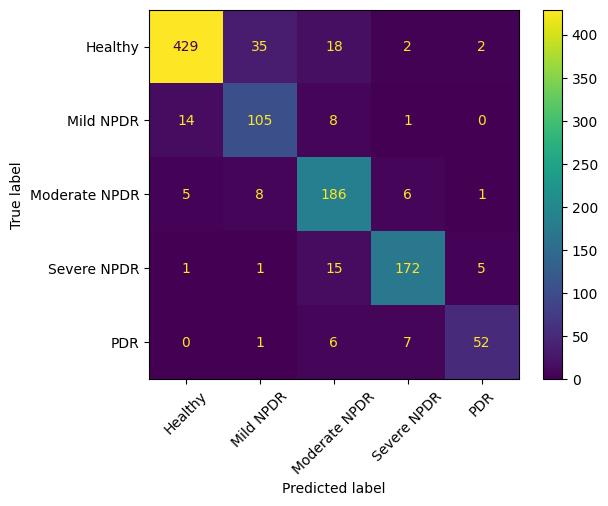

In [ ]:
# Evaluation with Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

outputs =                                                                       #TO DO
y_true =                                                                        #TO DO
y_pred =                                                                        #TO DO

cm = confusion_matrix(y_true, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_map.values())
disp.plot(xticks_rotation=45)

In [ ]:
# Evaluation Precision, Recall, F1 Scores
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average=None)
precision, recall, f1_score, support

(array([0.95545657, 0.7       , 0.79828326, 0.91489362, 0.86666667]),
 array([0.88271605, 0.8203125 , 0.90291262, 0.88659794, 0.78787879]),
 array([0.91764706, 0.75539568, 0.84738041, 0.90052356, 0.82539683]),
 array([486, 128, 206, 194,  66]))

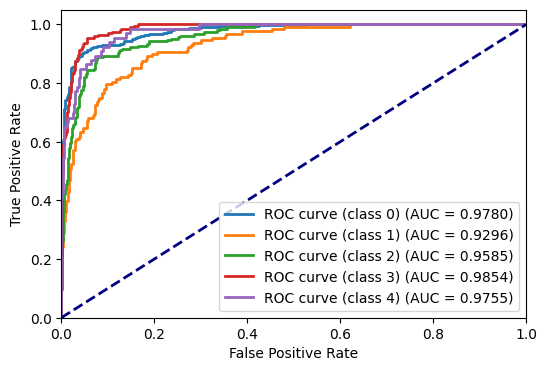

In [ ]:
# Evaluation with ROC Curves**

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have predictions and true labels for multi-class classification
# predictions shape: (num_samples, num_classes), where each row contains class probabilities
# true_labels shape: (num_samples,), where each value represents the true class label
true_labels =                                                                   #TO DO
predictions =                                                                   #TO DO

# Compute ROC curve for each class
num_classes = predictions.shape[1]  # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((true_labels == i).astype(int), predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(6, 4))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class %d) (AUC = %0.4f)' % (i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
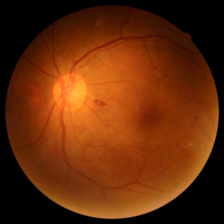

In [ ]:
test_data.imgs[idx]

#### Bonus Functionality - Model interpretation with Class Activation Mapping (CAM)

Now that we understand how to build models from scratch and utilize transfer learning, we can apply this knowledge to create a new and highly useful functionality: the *class activation map*. This tool provides insight into why a computer vision neural network (such as CNNs or transformers) made specific predictions.

Class Activation Mapping (CAM) was introduced by Zhou et al. in 2015 in their paper [Learning Deep Features for Discriminative Localization](https://arxiv.org/abs/1512.04150). CAM uses the output from the last convolutional layer of a model (just before average pooling) along with the predictions to generate a heatmap that visualizes the reasoning behind the network's decisions. This makes it a valuable tool for interpretation. G

More specifically, at each position of the final convolutional layer, there are as many filters as the last linear layer. By computing the dot product of these activations with the final weights, we can determine the score for each location on the feature map, indicating the features that influenced the decision.

A popular variation of the CAM technique is the Gradient-weighted Class Activation Mapping (Grad-CAM) utilizes the gradients of a specific target concept flowing into the final convolutional layer to create a coarse localization map. This map highlights important regions in the image that are crucial for predicting the concept. Grad-CAM was introduced by Selvaraju, R. et al. 2016 in their paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391).

In [ ]:
# Save five random images to test gramcad
for i in range(5):
  idx = random.randint(0,len(test_data.imgs)-1)
  img = Img.fromarray(test_data.imgs[idx], 'RGB')
  img.save(f'retina{i}.png')

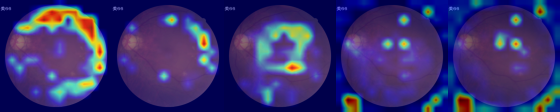

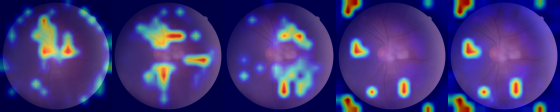

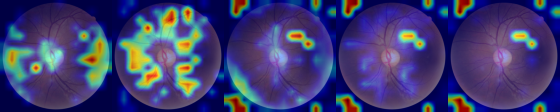

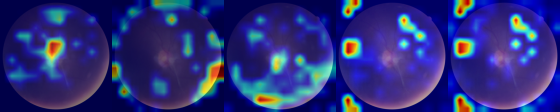

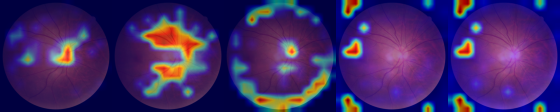

In [ ]:
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional
from transformers import ViTForImageClassification
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Model wrapper to return a tensor
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        return self.model(x).logits


# Helper function to run GradCAM on an image and create a visualization
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module,
                          input_image: Image,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:

        # Replicate the tensor for each of the categories we want to create Grad-CAM for
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)

        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            # Make it weight less in the notebook
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1]//2, visualization.shape[0]//2))
            results.append(visualization)
        return np.hstack(results)

# Define the reshape transform for ViT model
def reshape_transform_vit_huggingface(x):
    activations = x[:, 1:, :]
    activations = activations.view(activations.shape[0],
                                   14, 14, activations.shape[2])
    activations = activations.transpose(2, 3).transpose(1, 2)
    return activations

# Define the target layer for GradCAM
target_layer_gradcam = model.vit.encoder.layer[-2].output

# Define the targets for GradCAM
targets_for_gradcam = [ClassifierOutputTarget(0),
                       ClassifierOutputTarget(1),
                       ClassifierOutputTarget(2),
                       ClassifierOutputTarget(3),
                       ClassifierOutputTarget(4),
                      ]

def process_images_with_grad_cam(images: List[str]):
    results = []
    for image_path in images:
        # Load the input image
        image = Image.open(image_path).convert("RGB")

        # Resize the input image to match the model's expected input size (224x224)
        image_resized = image.resize((224, 224))

        # Convert the resized image into a tensor
        tensor_resized = transforms.ToTensor()(image_resized)

        # Run Grad-CAM on the resized image
        visualization = run_grad_cam_on_image(model=model,
                                              target_layer=target_layer_gradcam,
                                              targets_for_gradcam=targets_for_gradcam,
                                              input_tensor=tensor_resized,
                                              input_image=image_resized,
                                              reshape_transform=reshape_transform_vit_huggingface)

        results.append(visualization)
    return results


image_paths = ["retina0.png", "retina1.png", "retina2.png", "retina3.png", "retina4.png"]
visualizations = process_images_with_grad_cam(images=image_paths)

# Display the visualizations
for visualization in visualizations:
    display(Image.fromarray(visualization))

### **Step 3) Run inference on new data**

In [ ]:
# Save model
torch.save(model.state_dict(), "medmnist_vit_pytorch.ckpt")

In [ ]:
# Make all predictions for test set
model.eval()
outputs =                                                                       #TO DO

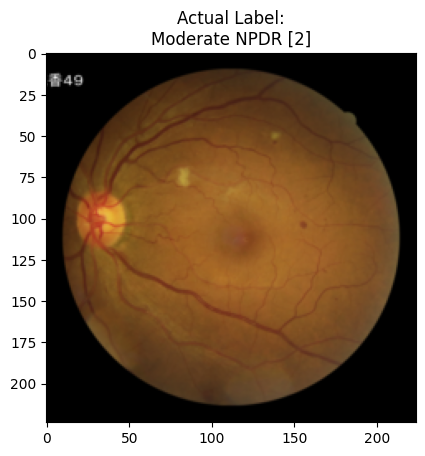

Predicted Label:
Moderate NPDR [2]


In [ ]:
# Select an image from the test set and test the model
idx=                                                                            #TO DO
img =                                                                           #TO DO
label =                                                                         #TO DO

# Visualize the image
plt.imshow(img)
plt.title(f"\n".join(wrap(f"Actual Label: {labels_map[label]}"+ " [" + str(label)+ "]", 20)))
plt.show()

pred =                                                                          #TO DO

print(f"\n".join(wrap(f"Predicted Label: {labels_map[pred.item()]}"+ " [" + str(pred.item())+ "]", 20)))

Grad-CAM for Classes 0 to 4


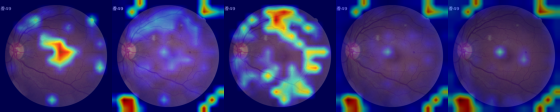

In [ ]:
# Save test image to get also gramcad
img_path = ['retina_test.png']
Img.fromarray(img, 'RGB').save(img_path[0])

visualizations =                                                                #TO DO
# Display the visualizations
for visualization in visualizations:
    print("Grad-CAM for Classes 0 to 4")
    display(Image.fromarray(visualization))

------------------------------------------------------
------------------------------------------------------